In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [15]:
def query( data, service ):
    df = data.query('service == "' + service + '"')
    df = df.reset_index()
    df = df.set_index(['lines'])
    #df = df.drop(df.index[0])
    return df

def plotRaw(data, service):
    df = query(dataLoadDetails, service)
    df = df.reset_index()
    durations = [ row.end - row.start for index, row in df.iterrows() ]
    #durations = [x if x >= 0 else -1 for x in durations]
    df['duration'] = durations
    df = df.drop(columns=['end','start','requestId'])
    df = df.set_index('document')
    fig = plt.figure()
    ax = df.plot.bar(stacked=True, title='Microservice response time ('+service+')', figsize=(15,7))
    ax.set_ylabel("Time (ms)")
    plt.tight_layout()
    
def load(file, sizes):
    df = pd.read_csv(file)
    df = df.merge(sizes, left_on='document', right_on='document')
    df = df.set_index(['lines','service'])
    df = df.groupby(['service','lines']).mean()
    df = df.transform(lambda x: x)
    return df

def plot(data1, data2 , name1, name2, service, language):
    data1 = data1.rename({'lines': 'lines', 'duration': name1}, axis=1)
    data2 = data2.rename({'lines': 'lines', 'duration': name2}, axis=1)
    concat = pd.concat([data1, data2], axis=1, sort=False)
    concat = query(concat, service)
    ax = concat.plot.bar(title='Language service response time ('+service+') - '+language)
    ax.set_ylabel("Time (ms)")
    ax.set_xlabel("File size (lines)")

def loadDetails(file, sizes):
    df = pd.read_csv(file)
    df = df.merge(sizes, left_on='document', right_on='document')
    df = df.drop(columns=['requestId','document'])
    df = df.groupby(['service','lines']).mean()
    df['router'] = df['router'] / 1000
    df['storage'] = df['storage'] / 1000
    df['workspace'] = df['workspace'] / 1000
    df['completion'] = df['completion'] / 1000
    df['definition'] = df['definition'] / 1000
    df['documentHightlight'] = df['documentHightlight'] / 1000
    df['documentSymbol'] = df['documentSymbol'] / 1000
    df['formatting'] = df['formatting'] / 1000
    df['hover'] = df['hover'] / 1000
    df['references'] = df['references'] / 1000
    df['rename'] = df['rename'] / 1000
    df['symbol'] = df['symbol'] / 1000
    df['load_model'] = df['load_model'] / 1000
    return df

def plotDetails(data, service, language):
    data = query(data, service)
    ax = data.plot.bar(stacked=True, colormap='jet', title='Language service details ('+service+') - '+language)
    ax.set_ylabel("Time (ms)")
    ax.set_xlabel("File size (lines)")
    
def loadIR(file):
    df = pd.read_csv(file)
    generation = [ (row.end - row.start) for index, row in df.iterrows() ]
    df['code generator'] = generation
    df = df.drop(columns=['end','start','elements','file','irElements'])
    df = df.groupby(['lines']).median()
    return df

def filterAndConcat(dataMonolith, dataDistributed, lines):
    df1 = dataMonolith.query('lines == "' + lines + '"')
    df1 = df1.reset_index()
    df1 = df1.set_index(['service'])
    df1 = df1.drop(columns=['lines'])
    df1 = df1.rename({'service': 'service', 'duration': 'monolithic'}, axis=1)
    df2 = dataDistributed.query('lines == "' + lines + '"')
    df2 = df2.reset_index()
    df2 = df2.set_index(['service'])
    df2 = df2.drop(columns=['lines'])
    df2 = df2.rename({'service': 'service', 'duration': 'distributed'}, axis=1)
    concat = pd.concat([df1, df2], axis=1, sort=False)
    return concat

def plotCompare(dataMonolith, dataDistributed, title, lines, ax):
    concat = filterAndConcat(dataMonolith,dataDistributed, lines)
    concat.plot.bar(ax=ax, title=title, figsize=(15,8))
    ax.set_ylabel("Time (ms)", labelpad=-2)
    
def plotCompareService(dataMonolith, dataDistributed, service, language, ax):
    df1 = query(dataMonolith,service)
    df2 = query(dataDistributed,service)
    df1 = df1.drop(columns=['service'])
    df2 = df2.drop(columns=['service'])
    df1 = df1.rename({'service': 'service', 'duration': 'monolithic'}, axis=1)
    df2 = df2.rename({'service': 'service', 'duration': 'distributed'}, axis=1)
    concat = pd.concat([df1, df2], axis=1, sort=False)
    concat.plot(ax=ax, title=service + ' - '+language, figsize=(15,30), marker='.')
    ax.set_ylabel("Time (ms)")
    
def plotCompareService2(dataMonolith, dataDistributed, service, language, ax):
    df1 = query(dataMonolith,service)
    df2 = query(dataDistributed,service)
    df1 = df1.drop(columns=['service'])
    df2 = df2.drop(columns=['service'])
    df1 = df1.rename({'service': 'service', 'duration': 'monolithic'}, axis=1)
    df2 = df2.rename({'service': 'service', 'duration': 'distributed'}, axis=1)
    concat = pd.concat([df1, df2], axis=1, sort=False)
    concat.plot(ax=ax, figsize=(15,7), marker='.')
    ax.set_title(service + ' - '+language, fontdict={'fontsize': 15, 'fontweight': 'medium'}, pad=15 )
    #ax.set_ylabel("Time (ms)", fontsize=15)
    ax.set_xlabel("")
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.legend(fontsize=15)
    
def ratio(data, dataDetail, service, line):
    total = data.loc[service].loc[line]['duration']
    service = (dataDetail.loc[service].loc[line][service]+dataDetail.loc[service].loc[line]['load_model']) / 1000
    return service/total

def compare( data1, data2, service, file ):
    val1 = query(data1,service).loc[file,'duration']
    val2 = query(data2,service).loc[file,'duration']
    return val2 - val1

def compareService(data1, data2, service, sizes):
    res = []
    for file in sizes["lines"].to_list():
        diff = compare(data1,data2, service, file)
        res.append(diff)
    return res

def compareMonoDistrib(data1,data2,sizes):
    df = pd.DataFrame()
    df['completion'] = compareService(data1,data2,'completion',sizes)
    df['definition'] = compareService(data1,data2,'definition',sizes)
    df['documentsymbol'] = compareService(data1,data2,'documentsymbol',sizes)
    df['formatting'] = compareService(data1,data2,'formatting',sizes)
    df['highlight'] = compareService(data1,data2,'highlight',sizes)
    df['hover'] = compareService(data1,data2,'hover',sizes)
    df['references'] = compareService(data1,data2,'references',sizes)
    df['rename'] = compareService(data1,data2,'rename',sizes)
    df['symbol'] = compareService(data1,data2,'symbol',sizes)
    df = pd.concat([df, sizes], axis=1, sort=False)
    df = df.set_index('lines')
    df = df.drop(columns=['document'])
    return df

def getOverheadTime(data, feature, microservice):
    return data.loc[feature]['router'] + data.loc[feature]['storage'] + data.loc[feature]['workspace']

def getOverheadTimes(data):
    df = pd.DataFrame()
    df['completion'] = getOverheadTime(data, 'completion', 'completion')
    df['definition'] = getOverheadTime(data, 'definition', 'definition')
    df['documentSymbol'] = getOverheadTime(data, 'documentsymbol', 'documentSymbol')
    df['highlight'] = getOverheadTime(data, 'highlight', 'documentHightlight')
    df['hover'] = getOverheadTime(data, 'hover', 'hover')
    #df['formatting'] = getOverheadTime(data, 'formatting', 'formatting')
    df['references'] = getOverheadTime(data, 'references', 'references')
    df['rename'] = getOverheadTime(data, 'rename', 'rename')
    df['symbol'] = getOverheadTime(data, 'symbol', 'symbol')
    return df

def getNonOverheadTimes(distributedTimes, overheadTimes, service, sizes):
    res = []
    for file in sizes["lines"].to_list():
        diff = distributedTimes.loc[service.lower()].loc[file]['duration'] - overheadTimes.loc[file][service]
        res.append(diff)
    return res

def getAllNonOverheadTimes(distributedTimes, overheadTimes, sizes):
    df = pd.DataFrame()
    df['lines'] = sizes['lines']
    df['completion'] = getNonOverheadTimes(distributedTimes, overheadTimes, 'completion', sizes)
    df['definition'] = getNonOverheadTimes(distributedTimes, overheadTimes, 'definition', sizes)
    df['documentSymbol'] = getNonOverheadTimes(distributedTimes, overheadTimes, 'documentSymbol', sizes)
    df['highlight'] = getNonOverheadTimes(distributedTimes, overheadTimes, 'highlight', sizes)
    df['hover'] = getNonOverheadTimes(distributedTimes, overheadTimes, 'hover', sizes)
    #df['formatting'] = getNonOverheadTimes(distributedTimes, overheadTimes, 'formatting', sizes)
    df['references'] = getNonOverheadTimes(distributedTimes, overheadTimes, 'references', sizes)
    df['rename'] = getNonOverheadTimes(distributedTimes, overheadTimes, 'rename', sizes)
    df['symbol'] = getNonOverheadTimes(distributedTimes, overheadTimes, 'symbol', sizes)
    df = df.set_index('lines')
    return df

def getServiceTime(data, feature, microservice):
    return data.loc[feature][microservice] + data.loc[feature]['load_model']

def getServiceTimes(data):
    df = pd.DataFrame()
    df['completion'] = getServiceTime(data, 'completion', 'completion')
    df['definition'] = getServiceTime(data, 'definition', 'definition')
    df['documentSymbol'] = getServiceTime(data, 'documentsymbol', 'documentSymbol')
    df['highlight'] = getServiceTime(data, 'highlight', 'documentHightlight')
    df['hover'] = getServiceTime(data, 'hover', 'hover')
    #df['formatting'] = getServiceTime(data, 'formatting', 'formatting')
    df['references'] = getServiceTime(data, 'references', 'references')
    df['rename'] = getServiceTime(data, 'rename', 'rename')
    df['symbol'] = getServiceTime(data, 'symbol', 'symbol')
    return df

def getNonServiceTimes(distributedTimes, serviceTimes, service, sizes):
    res = []
    for file in sizes["lines"].to_list():
        diff = distributedTimes.loc[service.lower()].loc[file]['duration'] - serviceTimes.loc[file][service]
        res.append(diff)
    return res

def getAllNonServiceTimes(distributedTimes, serviceTimes, sizes):
    df = pd.DataFrame()
    df['lines'] = sizes['lines']
    df['completion'] = getNonServiceTimes(distributedTimes, serviceTimes, 'completion', sizes)
    df['definition'] = getNonServiceTimes(distributedTimes, serviceTimes, 'definition', sizes)
    df['documentSymbol'] = getNonServiceTimes(distributedTimes, serviceTimes, 'documentSymbol', sizes)
    df['highlight'] = getNonServiceTimes(distributedTimes, serviceTimes, 'highlight', sizes)
    df['hover'] = getNonServiceTimes(distributedTimes, serviceTimes, 'hover', sizes)
    #df['formatting'] = getNonServiceTimes(distributedTimes, serviceTimes, 'formatting', sizes)
    df['references'] = getNonServiceTimes(distributedTimes, serviceTimes, 'references', sizes)
    df['rename'] = getNonServiceTimes(distributedTimes, serviceTimes, 'rename', sizes)
    df['symbol'] = getNonServiceTimes(distributedTimes, serviceTimes, 'symbol', sizes)
    df = df.set_index('lines')
    return df

def plotMonoDistribOverhead(dataMono, dataDistrib, nonServiceTimes, size, ax) :
    concat = filterAndConcat(dataMono,dataDistrib, size)
    concat = concat.query('service != "formatting"')
    concat.plot.bar(figsize=(20,4), edgecolor='black', width=0.7, ax=ax)
    ax.set_title(size+' lines', fontdict={'fontsize': 20, 'fontweight': 'medium'}, pad=15 )
    ax.set_ylim(0, 1000)
    #ax.set_ylabel("Time (ms)", fontsize=15)
    ax.set_xlabel("", fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=20)
    nonServiceTimes = nonServiceTimes.drop(columns=['formatting'])
    nonServiceTimes.loc[int(size)].plot.bar(position=-0.00, ax=ax, color='lightgrey', width=0.35, edgecolor='black')
    #p = Patch(facecolor='lightgrey', edgecolor='black',label='Overhead')
    #handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles[:2]+[p],labels[:2]+['requests overhead'], fontsize=15)
    
def plotMonoDistribOverhead2(dataMono, dataDistrib, nonServiceTimes, size, ax) :
    concat = filterAndConcat(dataMono,dataDistrib, size)
    concat = concat.query('service != "formatting"')
    concat.plot.bar(figsize=(10,12), edgecolor='black', width=0.7, ax=ax)
    ax.set_title(size+' lines of code', fontdict={'fontsize': 20, 'fontweight': 'medium'}, pad=15 )
    ax.set_ylim(0, 1000)
    #ax.set_ylabel("Time (ms)", fontsize=15)
    ax.set_xlabel("", fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=20)
    #nonServiceTimes = nonServiceTimes.drop(columns=['formatting'])
    nonServiceTimes.loc[int(size)].plot.bar(position=-0.00, ax=ax, color='lightgrey', width=0.35, edgecolor='black')


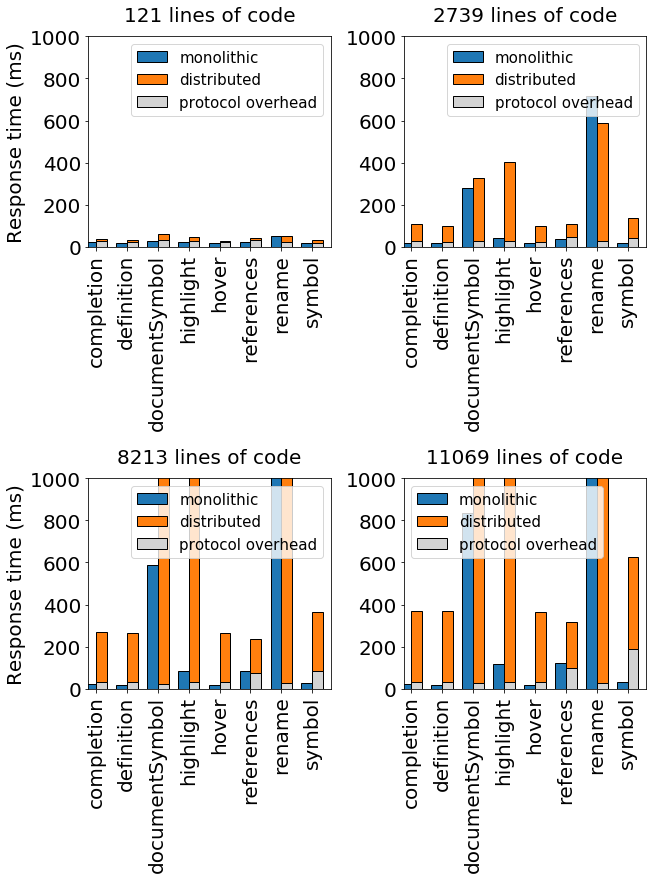

In [21]:
nablabSizes4 = pd.read_csv('eval/documentSizeNablab.csv')
df_nablab_monolith3 = load('eval/nablab-monolith-dataDurations.csv', nablabSizes4)
df_nablab_distributed3 = load('eval/nablab-distributed-dataDurations.csv', nablabSizes4)
df_nablab_distributedDetails3 = loadDetails("eval/nablab-distributed-dataDurationsDetails.csv",nablabSizes4)

nablabOverheadTimes = getOverheadTimes(df_nablab_distributedDetails3)
#nablabNonOverheadTimes = getAllNonOverheadTimes(df_nablab_distributed3, nablabOverheadTimes, nablabSizes3)

#fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, gridspec_kw={'hspace': 0.9, 'wspace': 0.05})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, gridspec_kw={'hspace': 1.1, 'wspace': 0.3})
plotMonoDistribOverhead2(df_nablab_monolith3,df_nablab_distributed3, nablabOverheadTimes, '121',ax1)
plotMonoDistribOverhead2(df_nablab_monolith3,df_nablab_distributed3, nablabOverheadTimes, '2739',ax2)
plotMonoDistribOverhead2(df_nablab_monolith3,df_nablab_distributed3, nablabOverheadTimes, '8213',ax3)
plotMonoDistribOverhead2(df_nablab_monolith3,df_nablab_distributed3, nablabOverheadTimes, '11069',ax4)

ax1.set_ylabel("Response time (ms)", fontsize=20)
ax3.set_ylabel("Response time (ms)", fontsize=20)
#ax2.legend().set_visible(False)
#ax3.legend().set_visible(False)
#ax4.legend().set_visible(False)
#ax1.tick_params(axis='both', which='major', labelsize=20)

#ax2.yaxis.set_ticklabels([])
#ax3.yaxis.set_ticklabels([])
#ax4.yaxis.set_ticklabels([])
ax1.set_ylim(0, 1000)
ax2.set_ylim(0, 1000)
ax3.set_ylim(0, 1000)
ax4.set_ylim(0, 1000)

p = Patch(facecolor='lightgrey', edgecolor='black',label='Overhead')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[:2]+[p],labels[:2]+['protocol overhead'], fontsize=15)
ax2.legend(handles[:2]+[p],labels[:2]+['protocol overhead'], fontsize=15)
ax3.legend(handles[:2]+[p],labels[:2]+['protocol overhead'], fontsize=15)
ax4.legend(handles[:2]+[p],labels[:2]+['protocol overhead'], fontsize=15)

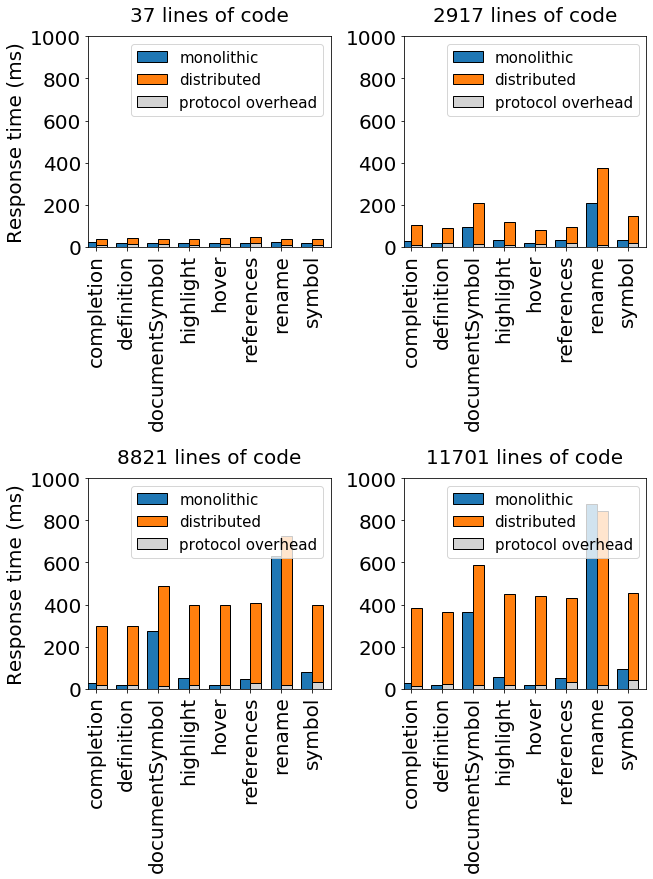

In [22]:
logoSizes4 = pd.read_csv('eval/documentSizeLogo.csv')
df_logo_monolith3 = load('eval/logo-monolith-dataDurations.csv', logoSizes4)
df_logo_distributed3 = load('eval/logo-distributed-dataDurations.csv', logoSizes4)
df_logo_distributedDetails3 = loadDetails("eval/logo-distributed-dataDurationsDetails.csv",logoSizes4)

logoOverheadTimes = getOverheadTimes(df_logo_distributedDetails3)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, gridspec_kw={'hspace': 1.1, 'wspace': 0.3})
plotMonoDistribOverhead2(df_logo_monolith3,df_logo_distributed3, logoOverheadTimes, '37',ax1)
plotMonoDistribOverhead2(df_logo_monolith3,df_logo_distributed3, logoOverheadTimes, '2917',ax2)
plotMonoDistribOverhead2(df_logo_monolith3,df_logo_distributed3, logoOverheadTimes, '8821',ax3)
plotMonoDistribOverhead2(df_logo_monolith3,df_logo_distributed3, logoOverheadTimes, '11701',ax4)

ax1.set_ylabel("Response time (ms)", fontsize=20)
ax3.set_ylabel("Response time (ms)", fontsize=20)

ax1.set_ylim(0, 1000)
ax2.set_ylim(0, 1000)
ax3.set_ylim(0, 1000)
ax4.set_ylim(0, 1000)

p = Patch(facecolor='lightgrey', edgecolor='black',label='Overhead')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[:2]+[p],labels[:2]+['protocol overhead'], fontsize=15)
ax2.legend(handles[:2]+[p],labels[:2]+['protocol overhead'], fontsize=15)
ax3.legend(handles[:2]+[p],labels[:2]+['protocol overhead'], fontsize=15)
ax4.legend(handles[:2]+[p],labels[:2]+['protocol overhead'], fontsize=15)

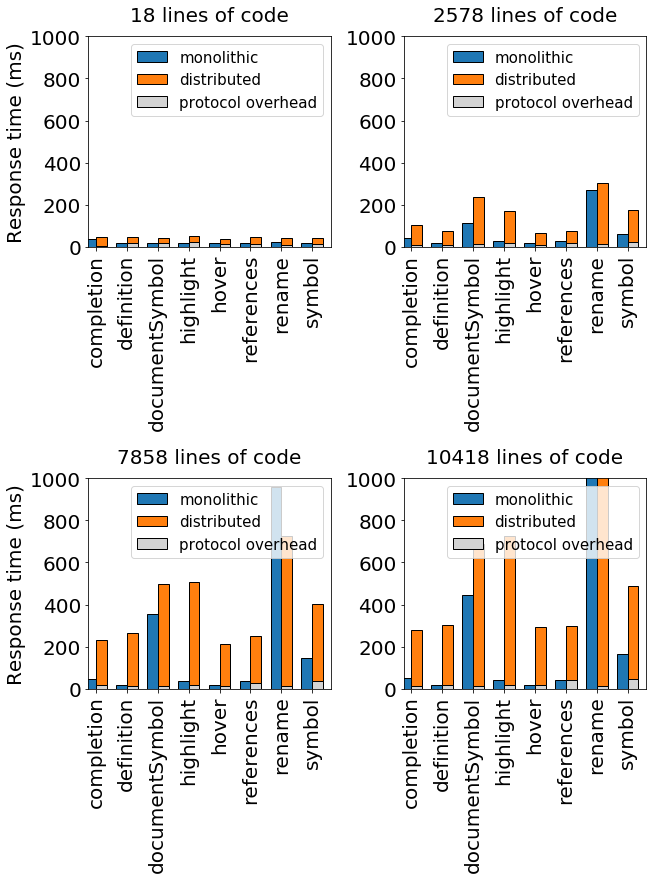

In [23]:
minijavaSizes4 = pd.read_csv('eval/documentSizeMinijava.csv')
df_minijava_monolith3 = load('eval/minijava-monolith-dataDurations.csv', minijavaSizes4)
df_minijava_distributed3 = load('eval/minijava-distributed-dataDurations.csv', minijavaSizes4)
df_minijava_distributedDetails3 = loadDetails("eval/minijava-distributed-dataDurationsDetails.csv",minijavaSizes4)

minijavaOverheadTimes = getOverheadTimes(df_minijava_distributedDetails3)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, gridspec_kw={'hspace': 1.1, 'wspace': 0.3})
plotMonoDistribOverhead2(df_minijava_monolith3,df_minijava_distributed3, minijavaOverheadTimes, '18',ax1)
plotMonoDistribOverhead2(df_minijava_monolith3,df_minijava_distributed3, minijavaOverheadTimes, '2578',ax2)
plotMonoDistribOverhead2(df_minijava_monolith3,df_minijava_distributed3, minijavaOverheadTimes, '7858',ax3)
plotMonoDistribOverhead2(df_minijava_monolith3,df_minijava_distributed3, minijavaOverheadTimes, '10418',ax4)
#plotMonoDistribOverhead2(df_minijava_monolith3,df_minijava_distributed3, minijavaOverheadTimes, '26',ax1)
#plotMonoDistribOverhead2(df_minijava_monolith3,df_minijava_distributed3, minijavaOverheadTimes, '3226',ax2)
#plotMonoDistribOverhead2(df_minijava_monolith3,df_minijava_distributed3, minijavaOverheadTimes, '9826',ax3)
#plotMonoDistribOverhead2(df_minijava_monolith3,df_minijava_distributed3, minijavaOverheadTimes, '13026',ax4)

ax1.set_ylabel("Response time (ms)", fontsize=20)
ax3.set_ylabel("Response time (ms)", fontsize=20)

ax1.set_ylim(0, 1000)
ax2.set_ylim(0, 1000)
ax3.set_ylim(0, 1000)
ax4.set_ylim(0, 1000)

p = Patch(facecolor='lightgrey', edgecolor='black',label='Overhead')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[:2]+[p],labels[:2]+['protocol overhead'], fontsize=15)
ax2.legend(handles[:2]+[p],labels[:2]+['protocol overhead'], fontsize=15)
ax3.legend(handles[:2]+[p],labels[:2]+['protocol overhead'], fontsize=15)
ax4.legend(handles[:2]+[p],labels[:2]+['protocol overhead'], fontsize=15)

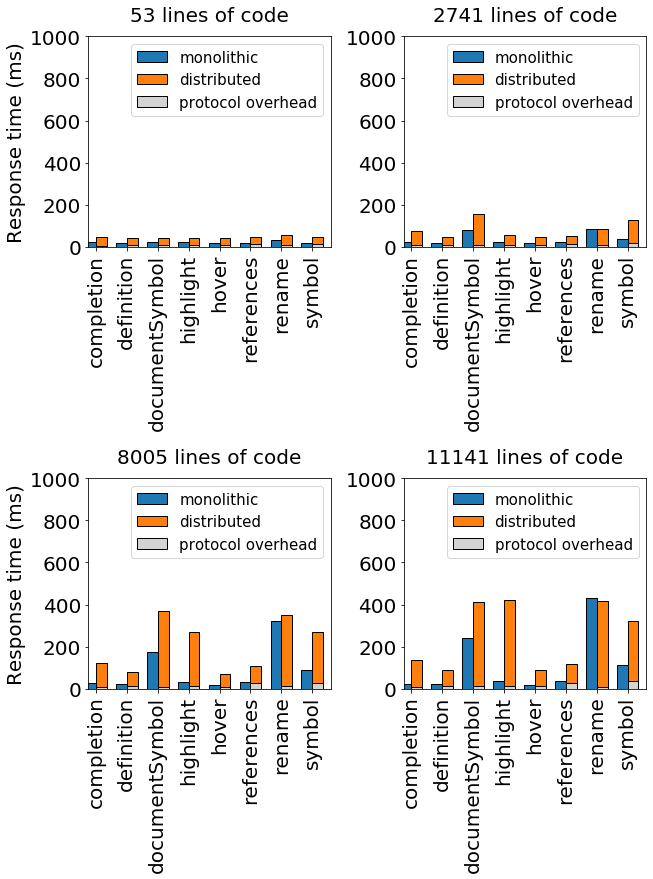

In [24]:
thingmlSizes4 = pd.read_csv('eval/documentSizeThingml.csv')
df_thingml_monolith4 = load('eval/thingml-monolith-dataDurations.csv', thingmlSizes4)
df_thingml_distributed4 = load('eval/thingml-distributed-dataDurations.csv', thingmlSizes4)
df_thingml_distributedDetails4 = loadDetails("eval/thingml-distributed-dataDurationsDetails.csv",thingmlSizes4)

thingmlOverheadTimes = getOverheadTimes(df_thingml_distributedDetails4)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, gridspec_kw={'hspace': 1.1, 'wspace': 0.3})
plotMonoDistribOverhead2(df_thingml_monolith4,df_thingml_distributed4, thingmlOverheadTimes, '53',ax1)
plotMonoDistribOverhead2(df_thingml_monolith4,df_thingml_distributed4, thingmlOverheadTimes, '2741',ax2)
plotMonoDistribOverhead2(df_thingml_monolith4,df_thingml_distributed4, thingmlOverheadTimes, '8005',ax3)
plotMonoDistribOverhead2(df_thingml_monolith4,df_thingml_distributed4, thingmlOverheadTimes, '11141',ax4)
#plotMonoDistribOverhead2(df_thingml_monolith3,df_thingml_distributed3, thingmlOverheadTimes, '81',ax1)
#plotMonoDistribOverhead2(df_thingml_monolith3,df_thingml_distributed3, thingmlOverheadTimes, '3249',ax2)
#plotMonoDistribOverhead2(df_thingml_monolith3,df_thingml_distributed3, thingmlOverheadTimes, '9761',ax3)
#plotMonoDistribOverhead2(df_thingml_monolith3,df_thingml_distributed3, thingmlOverheadTimes, '12929',ax4)

ax1.set_ylabel("Response time (ms)", fontsize=20)
ax3.set_ylabel("Response time (ms)", fontsize=20)

ax1.set_ylim(0, 1000)
ax2.set_ylim(0, 1000)
ax3.set_ylim(0, 1000)
ax4.set_ylim(0, 1000)

p = Patch(facecolor='lightgrey', edgecolor='black',label='Overhead')
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[:2]+[p],labels[:2]+['protocol overhead'], fontsize=15)
ax2.legend(handles[:2]+[p],labels[:2]+['protocol overhead'], fontsize=15)
ax3.legend(handles[:2]+[p],labels[:2]+['protocol overhead'], fontsize=15)
ax4.legend(handles[:2]+[p],labels[:2]+['protocol overhead'], fontsize=15)

Text(0.5, 0, 'Lines of code')

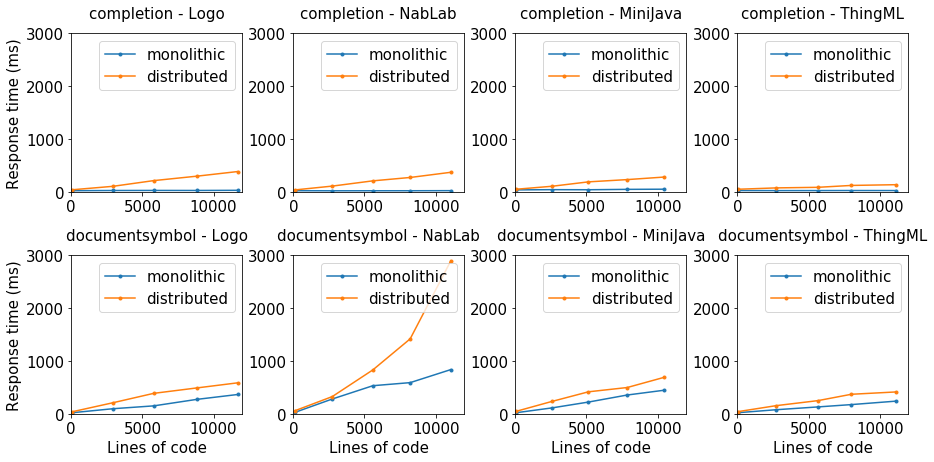

In [20]:
fig, ((ax1, ax2, ax3, ax4),
     (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, gridspec_kw={'hspace': 0.4, 'wspace': 0.3})

plotCompareService2(df_logo_monolith3,df_logo_distributed3,'completion','Logo',ax1)
plotCompareService2(df_nablab_monolith3,df_nablab_distributed3,'completion','NabLab',ax2)
plotCompareService2(df_minijava_monolith3,df_minijava_distributed3,'completion','MiniJava',ax3)
plotCompareService2(df_thingml_monolith4,df_thingml_distributed4,'completion','ThingML',ax4)

plotCompareService2(df_logo_monolith3,df_logo_distributed3,'documentsymbol','Logo',ax5)
plotCompareService2(df_nablab_monolith3,df_nablab_distributed3,'documentsymbol','NabLab',ax6)
plotCompareService2(df_minijava_monolith3,df_minijava_distributed3,'documentsymbol','MiniJava',ax7)
plotCompareService2(df_thingml_monolith4,df_thingml_distributed4,'documentsymbol','ThingML',ax8)

ax1.set_ylim(0, 3000)
ax2.set_ylim(0, 3000)
ax3.set_ylim(0, 3000)
ax4.set_ylim(0, 3000)
ax5.set_ylim(0, 3000)
ax6.set_ylim(0, 3000)
ax7.set_ylim(0, 3000)
ax8.set_ylim(0, 3000)

ax1.set_xlim(0, 12000)
ax2.set_xlim(0, 12000)
ax3.set_xlim(0, 12000)
ax4.set_xlim(0, 12000)
ax5.set_xlim(0, 12000)
ax6.set_xlim(0, 12000)
ax7.set_xlim(0, 12000)
ax8.set_xlim(0, 12000)

ax1.set_ylabel("Response time (ms)", fontsize=15)
ax5.set_ylabel("Response time (ms)", fontsize=15)

ax5.set_xlabel("Lines of code", fontsize=15)
ax6.set_xlabel("Lines of code", fontsize=15)
ax7.set_xlabel("Lines of code", fontsize=15)
ax8.set_xlabel("Lines of code", fontsize=15)